## import libraries

In [4]:
import open3d as o3d
import numpy as np
import os
import random
import pandas as pd
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt
#00100356

## data random visualization

In [1]:
# 폴더 경로 설정
points_folder = 'D:/work/data/auto/3d_mod_av_db/points'
labels_folder = 'D:/work/data/auto/3d_mod_av_db/labels'

# .npy 파일 목록 가져오기
npy_files = [f for f in os.listdir(points_folder) if f.endswith('.npy')]

# 랜덤으로 하나의 .npy 파일 선택
random_file = random.choice(npy_files)
file_number = os.path.splitext(random_file)[0]  # 파일명에서 확장자 제거

# LiDAR 데이터를 NumPy 배열로 불러오기
data1 = np.load(os.path.join(points_folder, random_file))

# 포인트 클라우드 객체 생성
pcd1 = o3d.geometry.PointCloud()

# X, Y, Z 좌표를 포인트 클라우드에 추가
pcd1.points = o3d.utility.Vector3dVector(data1[:, :3])

# 라벨 파일 읽기 함수
def load_labels(file_path):
    labels = []
    with open(file_path, 'r') as f:
        for line in f:
            parts = line.strip().split()
            x, y, z = map(float, parts[:3])  # 중심 좌표
            length, width, height = map(float, parts[3:6])  # 크기
            yaw = float(parts[6])  # 회전 각도
            label = parts[7]  # 클래스 이름 (예: "Vehicle")
            labels.append([x, y, z, length, width, height, yaw, label])
    return labels

# 라벨 파일 경로
label_file = os.path.join(labels_folder, f'{file_number}.txt')
label_data = load_labels(label_file)

# Bounding Box와 텍스트를 시각화할 요소 리스트
geometry_list = [pcd1]

# 각 라벨 데이터를 처리하여 Bounding Box와 텍스트를 시각화
for label in label_data:
    # 중심 좌표 (x, y, z)
    center = np.array([label[0], label[1], label[2]])

    # 크기 (길이, 너비, 높이)
    length, width, height = label[3], label[4], label[5]

    # 회전 각도 (yaw)
    yaw = label[6]

    # Open3D 직육면체 생성
    box = o3d.geometry.OrientedBoundingBox()
    box.center = center
    box.extent = np.array([length, width, height])

    # Yaw 각도를 회전 행렬로 변환하여 적용 (yaw는 z축 회전을 의미)
    R = box.get_rotation_matrix_from_xyz((0, 0, yaw))
    box.rotate(R, center=box.center)

    # Bounding box 색상 설정 (빨간색으로 설정)
    box.color = (1, 0, 0)

    # Bounding box 추가
    geometry_list.append(box)

# 포인트 클라우드와 bounding box 함께 시각화
o3d.visualization.draw_geometries(geometry_list)


Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


## Summary Statistics

###### 저는 노트북이라 1000개로 했습니당 .. ㅜㅜ 전체 데이터셋으로 돌려주실 데탑 구해요..

In [2]:
# 데이터셋 폴더 경로
data_folder = 'D:/work/data/auto/3d_mod_av_db/points/'
label_folder = 'D:/work/data/auto/3d_mod_av_db/labels/'

# 전체 데이터를 저장할 리스트
all_points = []
all_labels = []

# 파일 리스트 불러오기 (train 데이터셋 전부)
file_list = os.listdir(data_folder)
file_list = [f for f in file_list if f.endswith('.npy')]

# 파일을 1000개로 제한
sampled_file_list = file_list[:1000]

# 각 파일을 반복적으로 불러오기 (1000개만)
for file_name in sampled_file_list:
    # 포인트 클라우드 데이터 불러오기
    data = np.load(os.path.join(data_folder, file_name))
    all_points.append(data)

    # 라벨 데이터 불러오기
    label_file = file_name.replace('.npy', '.txt')
    label_data = load_labels(os.path.join(label_folder, label_file))
    all_labels.extend(label_data)

# 1000개 파일의 포인트 클라우드를 하나로 합치기
all_points = np.vstack(all_points)

# 포인트 클라우드 데이터 분석
df_points = pd.DataFrame(all_points[:, :3], columns=['X', 'Y', 'Z'])
print("1000개 샘플 포인트 클라우드 통계 요약")
print(df_points.describe())

# 라벨 클래스 분포 분석
label_classes = [label[-1] for label in all_labels]
class_counts = Counter(label_classes)

print("1000개 샘플 클래스 분포:")
for cls, count in class_counts.items():
    print(f"{cls}: {count}")


1000개 샘플 포인트 클라우드 통계 요약
                  X             Y             Z
count  1.193863e+08  1.193863e+08  1.193863e+08
mean   1.292772e+00  1.299346e+00  1.262697e+00
std    1.644928e+01  1.410342e+01  1.410282e+00
min   -6.999998e+01 -6.999992e+01 -4.065072e+01
25%   -6.040695e+00 -6.066164e+00  4.493821e-01
50%    1.120000e+00  1.314832e-01  1.159857e+00
75%    8.422773e+00  7.173555e+00  1.647730e+00
max    6.999998e+01  6.999994e+01  2.869422e+01
1000개 샘플 클래스 분포:
Vehicle: 18086
Pedestrian: 9453
Cyclist: 1602


## 이상치, 결측치 확인
###### 3D LiDAR 포인트 클라우드 데이터에서 이상치 탐색은 센서 오류나 물리적으로 불가능한 값으로 인한 학습 오류를 방지하기 위해, 결측치 탐색은 데이터 누락으로 인한 모델 성능 저하를 막기 위해 필요함.

#### 클래스별 Bounding Box 크기 분포 비교

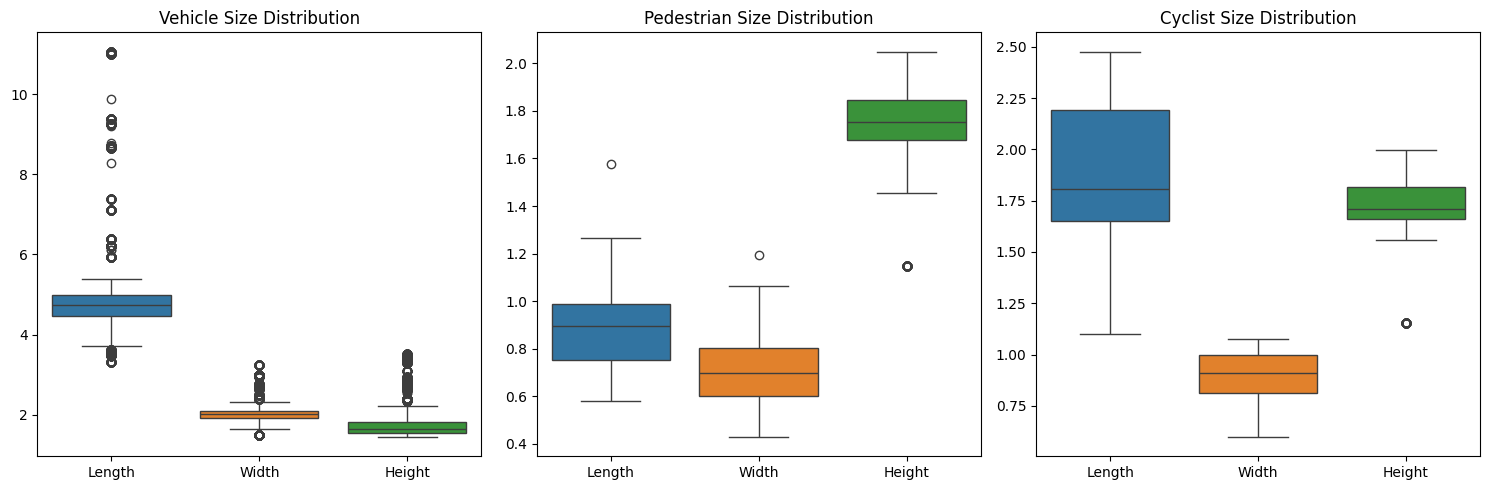

In [29]:

# 각 클래스별 Bounding Box 크기 분포를 확인
vehicle_dims = [label[3:6] for label in all_labels if label[7] == 'Vehicle']
pedestrian_dims = [label[3:6] for label in all_labels if label[7] == 'Pedestrian']
cyclist_dims = [label[3:6] for label in all_labels if label[7] == 'Cyclist']

# 데이터프레임으로 변환
vehicle_df = pd.DataFrame(vehicle_dims, columns=['Length', 'Width', 'Height'])
pedestrian_df = pd.DataFrame(pedestrian_dims, columns=['Length', 'Width', 'Height'])
cyclist_df = pd.DataFrame(cyclist_dims, columns=['Length', 'Width', 'Height'])

# 분포 시각화
plt.figure(figsize=(15, 5))

# Vehicle 크기
plt.subplot(1, 3, 1)
sns.boxplot(data=vehicle_df)
plt.title("Vehicle Size Distribution")

# Pedestrian 크기
plt.subplot(1, 3, 2)
sns.boxplot(data=pedestrian_df)
plt.title("Pedestrian Size Distribution")

# Cyclist 크기
plt.subplot(1, 3, 3)
sns.boxplot(data=cyclist_df)
plt.title("Cyclist Size Distribution")

plt.tight_layout()
plt.show()


###### Length (길이): 차량의 길이는 대체로 3m ~ 6m 범위에 분포하고, 7m 이상은 드물게 나타남. 7m 이상을 이상치로 간주.
###### Width (너비): 차량의 너비는 대부분 2m 이하로 나타나며, 2.5m 이상은 이상치로 간주.
###### Height (높이): 차량의 높이는 대부분 2m 이하로, 2.5m 이상은 이상치로 간주.

In [31]:

# 각 클래스의 기준 (앞서 정의한 기준 사용)
vehicle_box_thresholds = {'Length': 7, 'Width': 2.5, 'Height': 2.5}
pedestrian_box_thresholds = {'Length': 1.5, 'Width': 0.8, 'Height': 2}
cyclist_box_thresholds = {'Length': 2.5, 'Width': 1.2, 'Height': 2.5}

# 이상치가 포함된 파일 및 해당 Bounding Box 찾기
data_folder = 'D:/work/data/auto/3d_mod_av_db/points/'
label_folder = 'D:/work/data/auto/3d_mod_av_db/labels/'

point_files = [f for f in os.listdir(data_folder) if f.endswith('.npy')]
label_files = [f.replace('.npy', '.txt') for f in point_files]

outlier_file = None
outlier_box = None

for point_file, label_file in zip(point_files, label_files):
    # 라벨 파일 로드
    label_data = load_labels(os.path.join(label_folder, label_file))

    for label in label_data:
        length, width, height = label[3], label[4], label[5]
        if label[7] == 'Vehicle' and (length > vehicle_box_thresholds['Length'] or width > vehicle_box_thresholds['Width'] or height > vehicle_box_thresholds['Height']):
            outlier_file = point_file
            outlier_box = label
            break
        elif label[7] == 'Pedestrian' and (length > pedestrian_box_thresholds['Length'] or width > pedestrian_box_thresholds['Width'] or height > pedestrian_box_thresholds['Height']):
            outlier_file = point_file
            outlier_box = label
            break
        elif label[7] == 'Cyclist' and (length > cyclist_box_thresholds['Length'] or width > cyclist_box_thresholds['Width'] or height > cyclist_box_thresholds['Height']):
            outlier_file = point_file
            outlier_box = label
            break
    if outlier_file:
        break

# 포인트 클라우드 데이터 시각화
if outlier_file:
    # 포인트 클라우드 로드
    data = np.load(os.path.join(data_folder, outlier_file))
    
    # 포인트 클라우드 객체 생성
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(data[:, :3])
    
    # 이상치 Bounding Box 정보
    x, y, z, length, width, height, yaw, label = outlier_box
    
    # Open3D Bounding Box 생성 및 파란색으로 설정
    box = o3d.geometry.OrientedBoundingBox()
    box.center = np.array([x, y, z])
    box.extent = np.array([length, width, height])

    # Yaw 각도를 회전 행렬로 변환하여 적용
    R = box.get_rotation_matrix_from_xyz((0, 0, yaw))
    box.rotate(R, center=box.center)

    # Bounding Box 색상 설정 (진한 파랑색)
    box.color = (0, 0, 1)

    # 포인트 클라우드와 Bounding Box 함께 시각화
    o3d.visualization.draw_geometries([pcd, box])
else:
    print("이상치 Bounding Box를 찾지 못했습니다.")


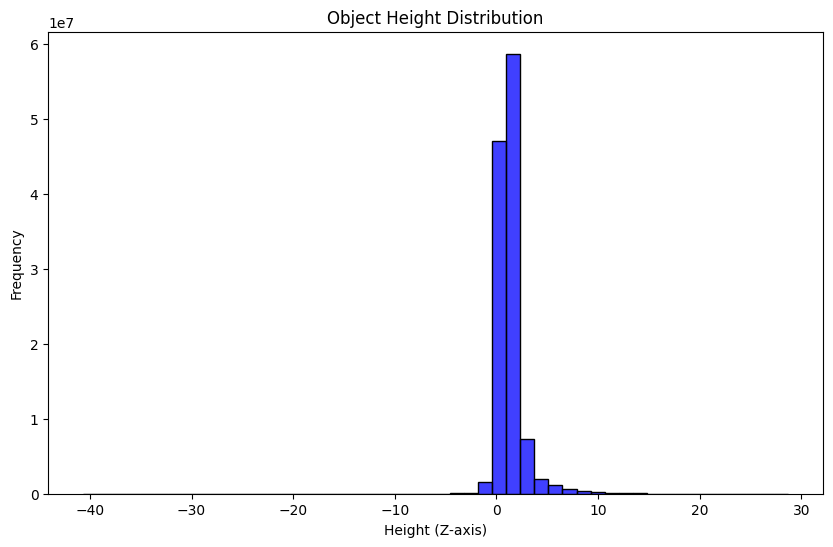

In [5]:
# Z축(높이) 기준으로 객체들의 높이 분포 시각화
heights = all_points[:, 2]

plt.figure(figsize=(10, 6))
sns.histplot(heights, bins=50, color='blue')
plt.title("Object Height Distribution")
plt.xlabel("Height (Z-axis)")
plt.ylabel("Frequency")
plt.show()


###### Z축인 높이 값의 분포를 나타내며, 대부분의 객체가 지면(높이 0)에 가깝게 위치해 있음.
###### 일부 객체는 음수 방향으로(지면 아래로) 상당히 떨어져 있음!(??) 높은 위치에도 라이다 3d 데이터 포인트 잡힘.
###### 높은 위치는 터널이거나 등등 으로 보임.

#### z값이 음수인 포인트를 가지는 데이터 시각화

###### 00100356.npy

In [12]:
import os
import random
import numpy as np
import open3d as o3d

# 폴더 경로 설정
points_folder = 'D:/work/data/auto/3d_mod_av_db/points'
labels_folder = 'D:/work/data/auto/3d_mod_av_db/labels'

# .npy 파일 목록 가져오기
npy_files = [f for f in os.listdir(points_folder) if f.endswith('.npy')]

# Z축 값이 음수인 파일들을 저장할 리스트
negative_z_files = []

# Z축 값이 음수인 파일을 탐색
for npy_file in npy_files:
    data = np.load(os.path.join(points_folder, npy_file))
    if np.any(data[:, 2] < 0):  # Z값이 음수인 데이터가 있는지 확인
        negative_z_files.append(npy_file)

# Z축 값이 음수인 파일 중 하나를 랜덤으로 선택
if negative_z_files:
    random_file = random.choice(negative_z_files)
    file_number = os.path.splitext(random_file)[0]  # 파일명에서 확장자 제거
    
    # LiDAR 데이터를 NumPy 배열로 불러오기
    data1 = np.load(os.path.join(points_folder, random_file))

    # 포인트 클라우드 객체 생성
    pcd1 = o3d.geometry.PointCloud()
    pcd1.points = o3d.utility.Vector3dVector(data1[:, :3])

    # 라벨 파일 읽기 함수
    def load_labels(file_path):
        labels = []
        with open(file_path, 'r') as f:
            for line in f:
                parts = line.strip().split()
                x, y, z = map(float, parts[:3])  # 중심 좌표
                length, width, height = map(float, parts[3:6])  # 크기
                yaw = float(parts[6])  # 회전 각도
                label = parts[7]  # 클래스 이름 (예: "Vehicle")
                labels.append([x, y, z, length, width, height, yaw, label])
        return labels

    # 라벨 파일 경로
    label_file = os.path.join(labels_folder, f'{file_number}.txt')
    label_data = load_labels(label_file)

    # Bounding Box와 텍스트를 시각화할 요소 리스트
    geometry_list = [pcd1]

    # 각 라벨 데이터를 처리하여 Bounding Box와 텍스트를 시각화
    for label in label_data:
        # 중심 좌표 (x, y, z)
        center = np.array([label[0], label[1], label[2]])

        # 크기 (길이, 너비, 높이)
        length, width, height = label[3], label[4], label[5]

        # 회전 각도 (yaw)
        yaw = label[6]

        # Open3D 직육면체 생성
        box = o3d.geometry.OrientedBoundingBox()
        box.center = center
        box.extent = np.array([length, width, height])

        # Yaw 각도를 회전 행렬로 변환하여 적용 (yaw는 z축 회전을 의미)
        R = box.get_rotation_matrix_from_xyz((0, 0, yaw))
        box.rotate(R, center=box.center)

        # Bounding box 색상 설정 (빨간색으로 설정)
        box.color = (1, 0, 0)

        # Bounding box 추가
        geometry_list.append(box)

    # 포인트 클라우드와 bounding box 함께 시각화
    o3d.visualization.draw_geometries(geometry_list)
else:
    print("Z축 값이 음수인 파일이 없습니다.")


[Open3D WARNING] GLFW Error: WGL: Failed to make context current: 요청한 변환 작업을 지원할 수 없습니다. 


###### 데이터 시각화 해보니까 z값이 음수인 포인터들이 있는데, 이런거 지워야 하나요?